# Growing Sample Plots

Make plots that show progression of main results as sample grows

### import modules

In [1]:
import json
import pickle

import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
sns.set_context('talk')

from matplotlib import animation
from IPython.display import HTML

from tqdm.notebook import tqdm

### get settings

In [2]:
with open('../models/palette7.pkl','rb') as fp:
    palette7 = pickle.load(fp)
    
with open('../references/my_settings.json', 'r') as fp:
    settings_dict = json.load(fp)

my_order = settings_dict['my_order']
my_boot = settings_dict['boots']
my_ci = settings_dict['ci']

## get data

### clicks

In [3]:
click_diff_correct_df = pd.read_csv('../data/processed/click_diff_correct_df.tsv', sep='\t', index_col=[0])
click_diff_correct_df = click_diff_correct_df.loc[:, my_order]
click_diff_correct_df.tail()

Happy  Disgusted   Neutral     Angry       Sad   Fearful  Surprised
p228  -0.21   0.060000  0.100000  0.320000  0.133333  0.250000   0.155556
p230   0.02   0.044444  0.062500  0.077778  0.122222  0.100000   0.155556
p231   0.03   0.037500  0.042857  0.160000 -0.016667  0.088889   0.110000
p232  -0.19   0.033333  0.077778  0.122222  0.066667  0.125000   0.110000
p233  -0.01   0.188889  0.083333  0.340000  0.137500  0.100000   0.077778

### answers

In [4]:
ans_diff_df = pd.read_csv('../data/processed/ans_diff_correct_df.tsv', sep='\t', index_col=[0], header=[0])
ans_diff_df = ans_diff_df.loc[:, my_order]
ans_diff_df.tail()

Happy  Disgusted  Neutral  Angry  Sad  Fearful  Surprised
p228   -0.2       -0.4     -0.2    0.3  0.1      0.4       -0.1
p230   -0.1       -0.4     -0.1    0.2  0.1      0.2        0.2
p231   -0.1       -0.8     -0.1    0.6 -0.4     -0.5        0.2
p232   -0.1       -0.6     -0.4    0.2  0.0      0.3        0.0
p233   -0.1       -0.3      0.1    0.9  0.4      0.3        0.0

### how do the data change as the sample grows?

get participant numbers as integers

In [5]:
def make_num_df(df):
    
    num_df = df.copy()
    
    num_df.loc[:, 'p_num'] = num_df.index
    num_df = num_df.melt(id_vars=['p_num'])
    num_df['num'] = num_df['p_num'].apply(lambda x:int(x.strip('p')))
    
    return num_df

copy participants as many times as the number of slices they belong to (i.e. first participant belongs to all slices, last participant only to one slice)

In [6]:
def make_slice_df(num_df):

    nums = sorted(set(num_df['num']))

    slice_df = pd.DataFrame()

    for n, i in enumerate(nums):

        idx = num_df[num_df['num']<=i].index
        this = num_df.loc[idx,:]
        this.loc[:,'slice'] = n+1
        slice_df = pd.concat([slice_df, this])

        slice_df.index = range(slice_df.shape[0])
    
    assert list(range(1, len(set(slice_df['slice']))+1)) == list(set(slice_df['slice'])), 'non-continuous numbers'
    
    return slice_df

### group data into slices

In [7]:
num_df = make_num_df(click_diff_correct_df)
click_slice_df = make_slice_df(num_df)
click_slice_df.tail()

p_num   variable     value  num  slice
143516  p228  Surprised  0.155556  228    202
143517  p230  Surprised  0.155556  230    202
143518  p231  Surprised  0.110000  231    202
143519  p232  Surprised  0.110000  232    202
143520  p233  Surprised  0.077778  233    202

In [8]:
num_df = make_num_df(ans_diff_df)
ans_slice_df = make_slice_df(num_df)
ans_slice_df.tail()

p_num   variable  value  num  slice
143516  p228  Surprised   -0.1  228    202
143517  p230  Surprised    0.2  230    202
143518  p231  Surprised    0.2  231    202
143519  p232  Surprised    0.0  232    202
143520  p233  Surprised    0.0  233    202

## Visualize

### make progression plot

In [9]:
def make_ax(slice_df, ax, my_boot=my_boot, palette7=palette7):
    
    ax = sns.lineplot(data=slice_df, 
                 x='slice', 
                 y='value', 
                 hue='variable', 
                 ci=settings_dict['ci'], 
                 n_boot=my_boot,
                 palette=palette7,
                 hue_order=my_order,
                 ax=ax)

    mean_vals = slice_df.groupby('variable').mean()['value'].sort_values()
    
    for j in mean_vals.index:
        ax.annotate(xy=(slice_df['slice'].max()+0.5, mean_vals[j]), fontsize=12, text=j )

    ax.axhline(0, color='k', linestyle=':', linewidth=2)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

    ax.get_legend().remove()
    sns.despine(trim=True)

    return ax

### combine into one figure

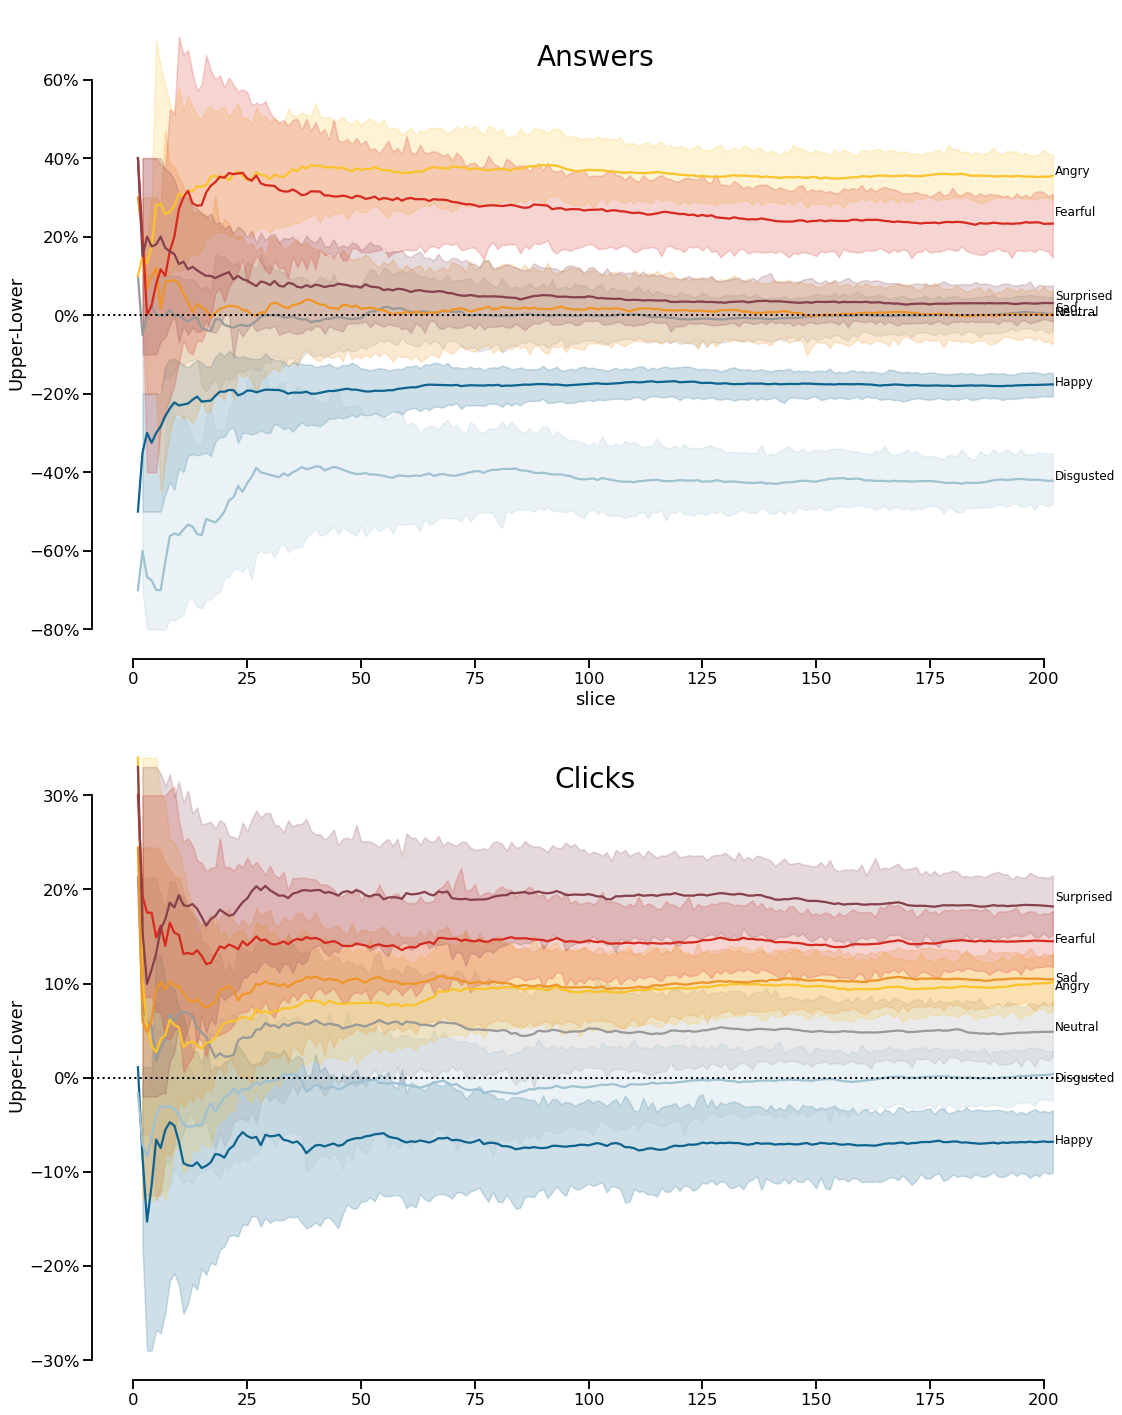

In [10]:
fig  = plt.figure(figsize=(16, 20))

ax = plt.subplot(2, 1, 1)
ax = make_ax(ans_slice_df, ax)
ax.set_title('Answers', y=0.9, fontsize=28)
ax.set_ylabel('Upper-Lower')

ax = plt.subplot(2, 1, 2)
ax = make_ax(click_slice_df, ax)
ax.set_title('Clicks', y=0.9, fontsize=28)
ax.set_ylabel('Upper-Lower')
ax.set_xlabel('')

plt.tight_layout()
plt.savefig('../reports/figures/sample_growth_fig.png', bbox_inches='tight', dpi=300)
plt.show()